In [132]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [102]:
def f(x):
    return 3 * x**2 - 4 * x + 5

In [103]:
f(3.0)

20.0

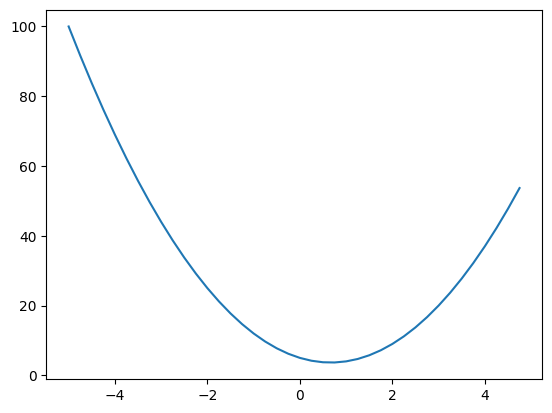

In [104]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs,ys)

In [105]:
h = 0.000001
x = -3.0
print(f"when {x=}, {(f(x + h) - f(x))/h=}")
x = 3.0
print(f"when {x=}, {(f(x + h) - f(x))/h=}")
x = 2/3
print(f"when {x=}, {(f(x + h) - f(x))/h=}")

when x=-3.0, (f(x + h) - f(x))/h=-21.999997002808414
when x=3.0, (f(x + h) - f(x))/h=14.000003002223593
when x=0.6666666666666666, (f(x + h) - f(x))/h=2.999378523327323e-06


In [106]:
# Getting more complex
a = 2.0
b = -3.0
c = 10.0
d = a * b + c
print(f"{d=}")

d=4.0


In [107]:
h = 0.0001

# Inputs
a = 2.0
b = -3.0
c = 10.0


print(f"slope when increasing {a = } by {h = }")
d1 = a * b + c
a += h
d2 = a * b + c
print(f"{d1 = }")
print(f"{d2 = }")
print(f"slope {(d2-d1)/h = }")
print("\n")

print(f"slope when increasing {b = } by {h = }")
d1 = a * b + c
b += h
d2 = a * b + c
print(f"{d1 = }")
print(f"{d2 = }")
print(f"slope {(d2-d1)/h = }")
print("\n")

print(f"slope when increasing {c = } by {h = }")
d1 = a * b + c
c += h
d2 = a * b + c
print(f"{d1 = }")
print(f"{d2 = }")
print(f"slope {(d2-d1)/h = }")
print("\n")

slope when increasing a = 2.0 by h = 0.0001
d1 = 4.0
d2 = 3.999699999999999
slope (d2-d1)/h = -3.000000000010772


slope when increasing b = -3.0 by h = 0.0001
d1 = 3.999699999999999
d2 = 3.99990001
slope (d2-d1)/h = 2.0001000000124947


slope when increasing c = 10.0 by h = 0.0001
d1 = 3.99990001
d2 = 4.00000001
slope (d2-d1)/h = 0.9999999999976694




In [108]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
        
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int,float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad
        out._backward = _backward
         
        return out

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other):
        return self * (other**-1)

    def __neg__(self): # -self
        return self * (-1)

    def __sub__(self, other): # self - other
        return self + (-other)

    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()


In [109]:
a = Value(2.0)
b = Value(4.0)
a - b

Value(data=-2.0)

In [110]:
from graphviz import Digraph

def trace(root):
    # Builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child,v))
                build(child)
        
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format = 'svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # For any value in the graph, create a rectangular (`record`) node for it
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # If this value is as a result of some operation, create an op node for it
            dot.node( name = uid + n._op, label = n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # Connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [111]:
# Inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# Weights w1, w2 of neuron
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# Bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# Weighted inputs plus bias i.e. x1*w1 + x2*w2 + b
x1w1 = x1*w1 ; x1w1.label = 'x1*w1'
x2w2 = x2*w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh() ; o.label ='o'

o.backward()

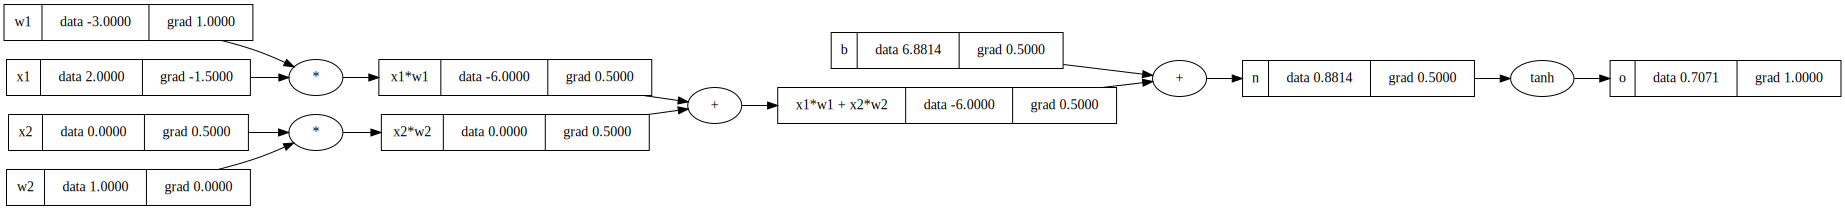

In [112]:
draw_dot(o)

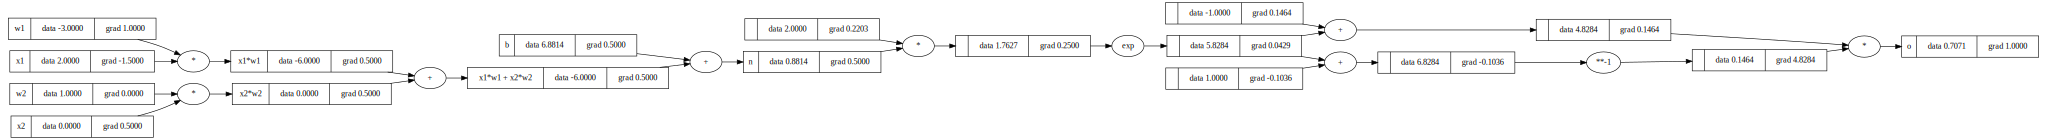

In [113]:
# Inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# Weights w1, w2 of neuron
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# Bias of the neuron
b = Value(6.8813735870195432, label = 'b')

# Weighted inputs plus bias i.e. x1*w1 + x2*w2 + b
x1w1 = x1*w1 ; x1w1.label = 'x1*w1'
x2w2 = x2*w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
#----
e = (2*n).exp()
o = (e - 1)/ (e + 1)
#----
o.label ='o'

o.backward()
draw_dot(o)

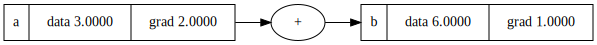

In [114]:
a = Value(3.0, label = 'a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

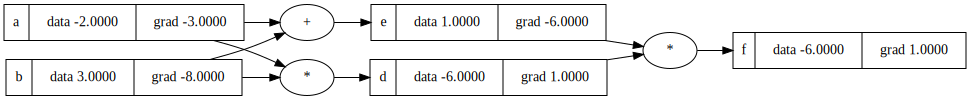

In [115]:
a = Value(-2.0, label = 'a')
b = Value(3.0, label = 'b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()
draw_dot(f)

In [127]:
import torch
x1 = torch.Tensor([2.0]).double()    ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()    ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()   ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()    ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()    ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()
print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [167]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b. Note: sum(iterable, start) adds up all elements in iterable, starting from start
        act = sum ((wi*xi for wi,xi in zip(self.w, x)), self.b) # Extra parens is because generator must be parenthesised to yield actual output
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]
        
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        #params = []
        #for neuron in self.neurons:
        #    ps = neuron.parameters()
        #    params.extend(ps)
        #return params
        # Above code is equivalent to the below list comprehension
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [ Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]




In [253]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.510956295672215)

In [254]:
len(n.parameters())

41

In [255]:
# Inputs and outputs for a binary classifier.
# Given 4 inputs xs, we expect them each to give the outputs in ys
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets


In [259]:
for k in range(40):
    # Forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # Zero out grads before starting backward pass
    for p in n.parameters():
        p.grad = 0.0
    # Backward pass
    loss.backward()

    # Update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    print(k, loss.data)

0 0.0035221404475918013
1 0.003494438360521139
2 0.0034671613849779574
3 0.0034402998780990214
4 0.0034138444853476276
5 0.003387786129843828
6 0.003362116002164092
7 0.003336825550586618
8 0.003311906471759808
9 0.0032873507017725434
10 0.003263150407606283
11 0.0032392979789502207
12 0.0032157860203615345
13 0.0031926073437537764
14 0.0031697549611978985
15 0.003147222078020413
16 0.0031250020861848795
17 0.0031030885579428546
18 0.0030814752397420753
19 0.003060156046379329
20 0.003039125055387068
21 0.0030183765016426906
22 0.002997904772190304
23 0.002977704401265333
24 0.0029577700655127118
25 0.0029380965793900865
26 0.002918678890747462
27 0.0028995120765757504
28 0.0028805913389166175
29 0.002861912000926348
30 0.0028434695030875277
31 0.002825259399561508
32 0.0028072773546760476
33 0.0027895191395420666
34 0.0027719806287942184
35 0.0027546577974498047
36 0.0027375467178812514
37 0.0027206435568973056
38 0.0027039445729284497
39 0.0026874461133121847


In [258]:
ypred

[Value(data=0.9816880749407929),
 Value(data=-0.9759704702295952),
 Value(data=-0.9624760045833544),
 Value(data=0.9649360233836043)]